In [1]:
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

import gc
import pegasus as pg
import pegasusio as io
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [2]:
data = pg.read_input("/lustre/scratch126/casm/team-cvejic/nelson/data/lung/scRNAseq/outputs/10X_Lung_Tumour_Annotated_v2.h5ad")

2024-01-11 16:08:47,588 - pegasusio.readwrite - INFO - h5ad file '/lustre/scratch126/casm/team-cvejic/nelson/data/lung/scRNAseq/outputs/10X_Lung_Tumour_Annotated_v2.h5ad' is loaded.
2024-01-11 16:08:47,589 - pegasusio.readwrite - INFO - Function 'read_input' finished in 126.34s.


In [3]:
data.obs.rename(columns={"Cell types v25": "latest_annot"}, inplace=True)
data.obs = data.obs[["patient", "sample", "latest_annot"]]

In [4]:
data = data[data.obs["latest_annot"].isin(["CAMLs"]), :].copy()

In [5]:
data

UnimodalData object with n_obs x n_vars = 2520 x 25718
    UID: unknown-rna; Genome: unknown; Modality: rna
    It contains 2 matrices: 'X', 'raw.X'
    It currently binds to matrix 'X' as X

    obs: 'patient', 'sample', 'latest_annot'
    var: 'feature_types', 'n_cells', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'X_pca', 'X_pca_harmonize', 'X_umap'
    uns: 'genome', 'modality', 'uid'

In [6]:
data.select_matrix("raw.X")

In [7]:
data.X[data.X > 5]

matrix([[5.1270666, 6.3631396, 5.1774883, ..., 6.7948937, 7.0311294,
         5.1744275]], dtype=float32)

In [8]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(data[:, "EPCAM"].X)
data.obs["subcluster_by_EPCAM"] = kmeans.labels_.tolist()
data.obs["subcluster_by_EPCAM"] = data.obs["subcluster_by_EPCAM"].astype("category")

In [9]:
sc.pl.heatmap(data.to_anndata(), var_names=["EPCAM"], groupby=["subcluster_by_EPCAM"], swap_axes=True, cmap="magma", show=False, figsize=(12, 1))

{'heatmap_ax': <Axes: >, 'groupby_ax': <Axes: xlabel='subcluster_by_EPCAM'>}

In [10]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(data.obsm["X_pca_harmonize"])
data.obs["subcluster_by_harmPC"] = kmeans.labels_.tolist()
data.obs["subcluster_by_harmPC"] = data.obs["subcluster_by_harmPC"].astype("category")

{'heatmap_ax': <Axes: >, 'groupby_ax': <Axes: xlabel='subcluster_by_harmPC'>}

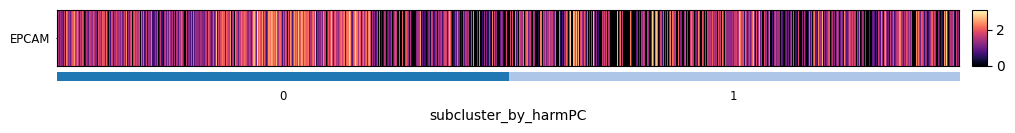

In [11]:
sc.pl.heatmap(data.to_anndata(), var_names=["EPCAM"], groupby=["subcluster_by_harmPC"], swap_axes=True, cmap="magma", show=False, figsize=(12, 1))

In [12]:
data.select_matrix("X")
data.X[data.X > 5]

matrix([[ 8., 44.,  9., ...,  6.,  6.,  9.]], dtype=float32)

In [13]:
data.obs["group_subcluster_by_EPCAM"] = data.obs["patient"].astype("str") + "_" + data.obs["subcluster_by_EPCAM"].astype("str")
data.obs["group_subcluster_by_harmPC"] = data.obs["patient"].astype("str") + "_" + data.obs["subcluster_by_harmPC"].astype("str")

In [14]:
pseudo_EPCAM = pg.pseudobulk(io.MultimodalData(data), sample="group_subcluster_by_EPCAM", attrs=["patient", "subcluster_by_EPCAM"], mat_key="X")
tab = pd.DataFrame(pseudo_EPCAM.X, index=pseudo_EPCAM.obs.index, columns=pseudo_EPCAM.var.index).T
tab.to_csv("/lustre/scratch126/casm/team-cvejic/haoliang/pj_NSCLC/results/scRNA-seq/check_CAMLs/pseudobulk_CAMLs.EPCAM.csv")
del pseudo_EPCAM, tab
gc.collect()

2024-01-11 16:08:53,101 - pegasus.tools.pseudobulk - INFO - Function 'pseudobulk' finished in 0.10s.


34322

In [15]:
pseudo_harmPC = pg.pseudobulk(io.MultimodalData(data), sample="group_subcluster_by_harmPC", attrs=["patient", "subcluster_by_harmPC"], mat_key="X")
tab = pd.DataFrame(pseudo_harmPC.X, index=pseudo_harmPC.obs.index, columns=pseudo_harmPC.var.index).T
tab.to_csv("/lustre/scratch126/casm/team-cvejic/haoliang/pj_NSCLC/results/scRNA-seq/check_CAMLs/pseudobulk_CAMLs.harmPC.csv")
del pseudo_harmPC, tab
gc.collect()

2024-01-11 16:08:53,524 - pegasus.tools.pseudobulk - INFO - Function 'pseudobulk' finished in 0.10s.


0